In [519]:
import numpy as np
import pandas as pd

pd.set_option("display.width", 1000)

In [520]:
logs = [
    "../log-simple-cloudflare",
    "../log-single-cloudflare",
    "../log-simple-client1",
    "../log-single-client1",
]


In [521]:
names = {
    "../log-simple-cloudflare-h2": "実験1 Cloudflare\nHTTP/2 /simple.html",
    "../log-simple-cloudflare-h3": "実験1 Cloudflare\nHTTP/3 /simple.html",
    "../log-single-cloudflare-h2": "実験1 Cloudflare\nHTTP/2 /single.html",
    "../log-single-cloudflare-h3": "実験1 Cloudflare\nHTTP/3 /single.html",
    "../log-simple-client1-h2": "実験1 NGINX\nHTTP/2 /simple.html",
    "../log-simple-client1-h3": "実験1 NGINX\nHTTP/3 /simple.html",
    "../log-single-client1-h2": "実験1 NGINX\nHTTP/2 /single.html",
    "../log-single-client1-h3": "実験1 NGINX\nHTTP/3 /single.html",
}


In [522]:
def analyze(
    df: pd.DataFrame, log: str, protocol: str
) -> tuple[pd.Series, pd.DataFrame]:
    df = df[
        ((df["protocol"] == "h2") | (df["protocol"] == "h3")) & (df["status"] == 200)
    ]
    # print(f"{df.size=}")

    df_groupby = df[["n", "startMili", "endMili", "baseUnixTime"]].groupby("n")

    # print(f'start = {df_groupby.min()["baseUnixTime"].min()}')
    # print(f'end = {df_groupby.max()["baseUnixTime"].max()}')

    df_groupby_count = df_groupby.count()["startMili"]
    df_success = df_groupby_count == df_groupby_count.mode()[0]
    # print(f"{df_success[df_success].size=}")

    df_mins = df_groupby.min()["startMili"]
    df_maxs = df_groupby.max()["endMili"]
    duration_df = df_maxs - df_mins
    duration_df = duration_df[df_success]

    duration_df_describe = duration_df.describe()
    duration_df_describe["filtered"] = False
    duration_df_describe["Path"] = f"{log}-{protocol}"

    df_lower_limit = duration_df_describe["mean"] - duration_df_describe["std"] * 3
    df_upper_limit = duration_df_describe["mean"] + duration_df_describe["std"] * 3

    duration_df_filtered = duration_df[
        (df_lower_limit < duration_df) & (duration_df < df_upper_limit)
    ]
    duration_df_filtered = duration_df_filtered.reset_index(drop=True)

    df_des = duration_df_filtered.describe()
    df_des["filtered"] = True
    df_des["Path"] = f"{log}-{protocol}"

    return (
        duration_df_filtered,
        pd.DataFrame(
            [duration_df_describe, df_des],
            # index=[f"{log}-{protocol}", f"{log}-{protocol}"],
        ),
    )


In [523]:
def compare(df: pd.DataFrame, descrives: pd.DataFrame, log: str):
    h2 = pd.read_json(log + "/h2-performances-processed.json")
    h3 = pd.read_json(log + "/h3-performances-prosessed.json")
    # print()
    # print(log)
    # print("h2")
    series_h2, result_h2 = analyze(h2, log, "h2")
    df[f"{log}-h2"] = series_h2
    descrives = pd.concat([descrives, result_h2])
    # print(result_h2)
    # print("h3")
    series_h3, result_h3 = analyze(h3, log, "h3")
    df[f"{log}-h3"] = series_h3
    descrives = pd.concat([descrives, result_h3])
    # print(result_h3)
    return df, descrives


In [524]:
results = pd.DataFrame()
describes = pd.DataFrame(
    columns=["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
)
for log in logs:
    (results, describes) = compare(results, describes, log)
print(results.count())
results.to_csv("client-time.csv")
describes = describes.sort_values("filtered")
describes["Path"] = describes["Path"].replace(names)
describes = describes.rename(
    columns={
        "Path": "実験",
        "count": "リクエスト数",
        "mean": "平均値",
        "std": "標準偏差",
        "min": "最小値",
        "25%": "第1四分数",
        "50%": "中央値",
        "75%": "第3四分数",
        "max": "最大",
    }
)
describes = describes.reindex(
    columns=[
        "実験",
        "リクエスト数",
        "平均値",
        "標準偏差",
        "最小値",
        "第1四分数",
        "中央値",
        "第3四分数",
        "最大",
        "filtered",
    ]
)
describes.to_csv("client-time-describe.csv")

describe_unfiltered = describes[describes["filtered"] == False].drop(
    columns=["filtered"]
)
describe_unfiltered.to_csv("client-time-describe-unfiltered.csv", index=False)
describe_filtered = describes[describes["filtered"] == True].drop(columns=["filtered"])
describe_filtered.to_csv("client-time-describe-filtered.csv", index=False)


/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h3])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:9: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h2])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h3])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:9: FutureW

../log-simple-cloudflare-h2    986
../log-simple-cloudflare-h3    986
../log-single-cloudflare-h2    986
../log-single-cloudflare-h3    986
../log-simple-client1-h2       986
../log-simple-client1-h3       986
../log-single-client1-h2       986
../log-single-client1-h3       986
dtype: int64


/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:9: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h2])
/var/folders/bf/kn4k8swd7vq0tzxz1_jvzsr80000gq/T/ipykernel_94867/2709141471.py:14: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  descrives = pd.concat([descrives, result_h3])


In [525]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

# print([f.name for f in matplotlib.font_manager.fontManager.ttflist])
font = {"family": "YuGothic"}
matplotlib.rc("font", **font)


In [526]:
describe_unfiltered

,実験,リクエスト数,平均値,標準偏差,最小値,第1四分数,中央値,第3四分数,最大
0,実験1 Cloudflare\nHTTP/2 /simple.html,1000.0,110.88100,25.448939,83.0,99.0,105.0,116.00,592.0
0,実験1 Cloudflare\nHTTP/3 /simple.html,1000.0,87.28200,16.988263,65.0,78.0,83.0,92.25,335.0
0,実験1 Cloudflare\nHTTP/2 /single.html,1000.0,1418.94600,12.940345,1390.0,1409.0,1417.0,1426.00,1478.0
0,実験1 Cloudflare\nHTTP/3 /single.html,1000.0,1416.23900,12.567809,1385.0,1407.0,1415.0,1423.25,1452.0
0,実験1 NGINX\nHTTP/2 /simple.html,1000.0,38.53300,1.884267,31.0,38.0,39.0,40.00,43.0
0,実験1 NGINX\nHTTP/3 /simple.html,1000.0,39.91600,1.891169,33.0,39.0,40.0,41.00,44.0
0,実験1 NGINX\nHTTP/2 /single.html,1000.0,1533.72400,44.745637,1429.0,1500.0,1531.0,1565.25,1654.0
0,実験1 NGINX\nHTTP/3 /single.html,999.0,1436.11011,2.705648,1425.0,1435.0,1436.0,1438.00,1444.0


In [527]:
describe_filtered

,実験,リクエスト数,平均値,標準偏差,最小値,第1四分数,中央値,第3四分数,最大
1,実験1 Cloudflare\nHTTP/2 /simple.html,986.0,109.007099,15.843298,83.0,99.0,104.0,115.00,186.0
1,実験1 Cloudflare\nHTTP/3 /simple.html,990.0,86.239394,12.133162,65.0,78.0,83.0,92.00,138.0
1,実験1 Cloudflare\nHTTP/2 /single.html,986.0,1418.254564,11.620615,1390.0,1409.0,1416.0,1426.00,1457.0
1,実験1 Cloudflare\nHTTP/3 /single.html,1000.0,1416.239000,12.567809,1385.0,1407.0,1415.0,1423.25,1452.0
1,実験1 NGINX\nHTTP/2 /simple.html,996.0,38.560241,1.838009,33.0,38.0,39.0,40.00,43.0
1,実験1 NGINX\nHTTP/3 /simple.html,990.0,39.978788,1.793301,35.0,39.0,40.0,41.00,44.0
1,実験1 NGINX\nHTTP/2 /single.html,1000.0,1533.724000,44.745637,1429.0,1500.0,1531.0,1565.25,1654.0
1,実験1 NGINX\nHTTP/3 /single.html,995.0,1436.151759,2.629749,1428.0,1435.0,1436.0,1438.00,1444.0


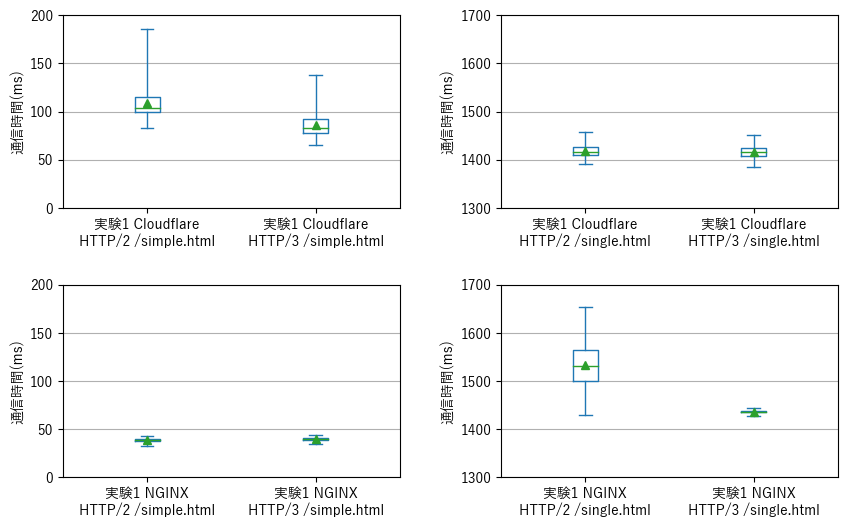

In [528]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

ploted = results[["../log-simple-cloudflare-h2", "../log-simple-cloudflare-h3"]].copy()
ploted.columns = [
    "実験1 Cloudflare\nHTTP/2 /simple.html",
    "実験1 Cloudflare\nHTTP/3 /simple.html",
]
ploted = ploted.plot.box(
    ax=axes[0, 0], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100]
)
ploted.grid(which="major", axis="y")
ploted.set_yticks([0, 50, 100, 150, 200])

ploted = results[["../log-single-cloudflare-h2", "../log-single-cloudflare-h3"]].copy()
ploted.columns = [
    "実験1 Cloudflare\nHTTP/2 /single.html",
    "実験1 Cloudflare\nHTTP/3 /single.html",
]
ploted = ploted.plot.box(
    ax=axes[0, 1], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100]
)
ploted.grid(which="major", axis="y")
ploted.set_yticks([1300, 1400, 1500, 1600, 1700])

ploted = results[["../log-simple-client1-h2", "../log-simple-client1-h3"]].copy()
ploted.columns = [
    "実験1 NGINX\nHTTP/2 /simple.html",
    "実験1 NGINX\nHTTP/3 /simple.html",
]
ploted = ploted.plot.box(
    ax=axes[1, 0], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100]
)
ploted.grid(which="major", axis="y")
ploted.set_yticks([0, 50, 100, 150, 200])

ploted = results[["../log-single-client1-h2", "../log-single-client1-h3"]].copy()
ploted.columns = [
    "実験1 NGINX\nHTTP/2 /single.html",
    "実験1 NGINX\nHTTP/3 /single.html",
]
ploted = ploted.plot.box(
    ax=axes[1, 1], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100]
)
ploted.grid(which="major", axis="y")
ploted.set_yticks([1300, 1400, 1500, 1600, 1700])


(1400.0, 1600.0)

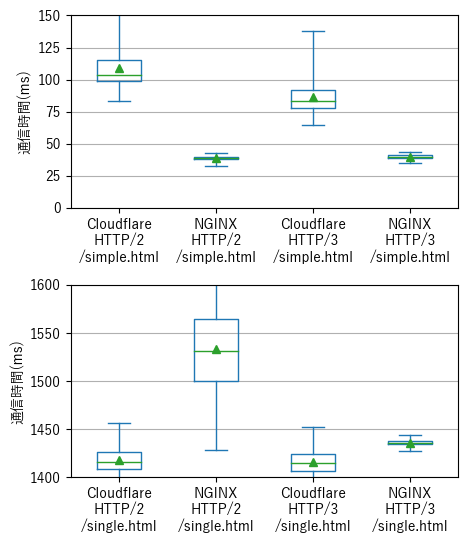

In [529]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

ploted = results[
    [
        "../log-simple-cloudflare-h2",
        "../log-simple-client1-h2",
        "../log-simple-cloudflare-h3",
        "../log-simple-client1-h3",
    ]
].copy()
ploted.columns = [
    "Cloudflare\nHTTP/2\n/simple.html",
    "NGINX\nHTTP/2\n/simple.html",
    "Cloudflare\nHTTP/3\n/simple.html",
    "NGINX\nHTTP/3\n/simple.html",
]
ploted = ploted.plot.box(ax=axes[0], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100])
ploted.grid(which="major", axis="y")
# ploted.set_yticks([0, 50, 100, 150])
ploted.set_ylim(0, 150)

ploted = results[
    [
        "../log-single-cloudflare-h2",
        "../log-single-client1-h2",
        "../log-single-cloudflare-h3",
        "../log-single-client1-h3",
    ]
].copy()
ploted.columns = [
    "Cloudflare\nHTTP/2\n/single.html",
    "NGINX\nHTTP/2\n/single.html",
    "Cloudflare\nHTTP/3\n/single.html",
    "NGINX\nHTTP/3\n/single.html",
]
ploted = ploted.plot.box(ax=axes[1], showmeans=True, ylabel="通信時間(ms)", whis=[0, 100])
ploted.grid(which="major", axis="y")
# ploted.set_yticks([1400, 1500, 1600])
ploted.set_ylim(1400, 1600)
